In [1]:
import torch
import os
import shutil
import cv2
import zipfile
import json
import random
import yaml
from PIL import Image
from roboflow import Roboflow
from sklearn.model_selection import train_test_split
import pybboxes as pbx
import glob
from collections import defaultdict
import matplotlib.pyplot as plt
from getpass import getpass

from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val
from super_gradients.training import models


from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from super_gradients.training import Trainer

from IPython.display import clear_output
from object_detection.src.data import extract_zip_datasets, generate_ground_truth

The console stream is logged into /home/LIBS/jozefov/sg_logs/console.log


[2024-12-16 21:46:46] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-12-16 21:46:46] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-12-16 21:46:47] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-12-16 21:46:47] WARNING - export.py - Failed to import pytorch_quantization
[2024-12-16 21:46:47] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
def download_roboflow_datasets(api_key, save_dir):
    """
    Downloads multiple Roboflow datasets and organizes them into separate directories.
    """
    rf = Roboflow(api_key=api_key)

    # Define datasets to download
    roboflow_datasets = [
        {
            "workspace": "hitsz",
            "project": "forklift-and-human",
            "version": "2"  # Changed to version 2 as per your working code
        },
        {
            "workspace": "paft",
            "project": "forklift-model",
            "version": "1"
        },
        {
            "workspace": "uqtr-2v1ej",
            "project": "forklift-9rs9h",
            "version": "1"
        }
    ]

    # Iterate over each dataset and download
    for ds_info in roboflow_datasets:
        workspace = ds_info["workspace"]
        project = ds_info["project"]
        version = ds_info["version"]

        print(f"Downloading Roboflow dataset: {workspace}/{project}/v{version}")
        project_rf = rf.workspace(workspace).project(project)
        dataset = project_rf.version(int(version)).download("yolov5")  # Ensure version is an integer

        # Move dataset to specific folder
        destination = os.path.join(save_dir, f"{project}_v{version}")
        os.makedirs(destination, exist_ok=True)
        for item in os.listdir(dataset.location):
            s = os.path.join(dataset.location, item)
            d = os.path.join(destination, item)
            if os.path.isdir(s):
                shutil.move(s, d)
            else:
                shutil.move(s, d)

    print(f"All Roboflow datasets downloaded and saved to {save_dir}")

# these functions are specific for mergin three roboflow dataset into one 

In [4]:
def merge_datasets(rf_dir, merged_dir):
    """
    Merges multiple Roboflow datasets into a unified directory structure compatible with COCO.

    Parameters:
    - rf_dir (str): Directory containing individual datasets.
    - merged_dir (str): Directory where the merged dataset will be stored.

    Returns:
    - None
    """
    # Define source splits and their corresponding destination splits
    split_mapping = {
        'train': 'train',
        'valid': 'val',    # Map 'valid' to 'val'
        'test': 'test'     # 'test' remains 'test'
    }
    
    # Define image and label split paths based on the mapping
    image_splits = {dest_split: os.path.join(merged_dir, dest_split) 
                   for dest_split in split_mapping.values()}
    label_splits = {dest_split: os.path.join(merged_dir, 'annotations', f'yolo_format_{dest_split}') 
                   for dest_split in split_mapping.values()}
    
    # Create merged directory structure
    for path in list(image_splits.values()) + list(label_splits.values()):
        os.makedirs(path, exist_ok=True)
    
    # Iterate through each dataset in rf_dir
    for dataset in os.listdir(rf_dir):
        dataset_path = os.path.join(rf_dir, dataset)
        if not os.path.isdir(dataset_path):
            continue  # Skip if not a directory

        print(f"Merging dataset: {dataset}")

        for src_split, dest_split in split_mapping.items():
            # Define source paths based on the correct directory structure
            src_images = os.path.join(dataset_path, src_split, 'images')
            src_labels = os.path.join(dataset_path, src_split, 'labels')

            # Check if source directories exist
            if not os.path.exists(src_images):
                print(f"Warning: {src_images} does not exist. Skipping.")
                continue
            if not os.path.exists(src_labels):
                print(f"Warning: {src_labels} does not exist. Skipping.")
                continue

            # Define destination paths
            dest_images = image_splits[dest_split]
            dest_labels = label_splits[dest_split]

            # Copy images
            for img_file in os.listdir(src_images):
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    src_img_path = os.path.join(src_images, img_file)
                    dest_img_path = os.path.join(dest_images, img_file)
                    if not os.path.exists(dest_img_path):
                        shutil.copy2(src_img_path, dest_img_path)

            # Copy labels
            for label_file in os.listdir(src_labels):
                if label_file.lower().endswith('.txt'):
                    src_label_path = os.path.join(src_labels, label_file)
                    dest_label_path = os.path.join(dest_labels, label_file)
                    if not os.path.exists(dest_label_path):
                        shutil.copy2(src_label_path, dest_label_path)

    print(f"All datasets have been merged into {merged_dir}")

In [5]:
def create_dataset_yaml(merged_dir, yaml_output_path, classes):
    """
    Creates a dataset.yaml file for YOLO-NAS.

    Parameters:
    - merged_dir (str): The directory where the merged dataset resides.
    - yaml_output_path (str): The path where the YAML file will be saved.
    - classes (list): List of class names.

    Returns:
    - None
    """
    # Initialize dataset_yaml with mandatory splits
    dataset_yaml = {
        'train': os.path.join(merged_dir, 'train'),
        'val': os.path.join(merged_dir, 'val'),
        'nc': len(classes),
        'names': classes
    }
    
    # Check if 'test' split exists
    test_dir = os.path.join(merged_dir, 'test')
    if os.path.exists(test_dir):
        dataset_yaml['test'] = test_dir
    
    with open(yaml_output_path, 'w') as f:
        yaml.dump(dataset_yaml, f)

    print(f"dataset.yaml has been created at {yaml_output_path}")


def count_instances(merged_labels_dir, classes):
    """
    Counts the number of instances per class in each split.

    Parameters:
    - merged_labels_dir (str): Directory containing label files organized by split.
    - classes (list): List of class names.

    Returns:
    - stats (dict): Nested dictionary with counts per split and per class.
    """
    stats = {
        'train': defaultdict(int),
        'val': defaultdict(int),
        'test': defaultdict(int)
    }

    splits = ['train', 'val', 'test']

    for split in splits:
        label_split_dir = os.path.join(merged_labels_dir, f'yolo_format_{split}')
        if not os.path.exists(label_split_dir):
            print(f"Warning: {label_split_dir} does not exist.")
            continue
        for label_file in os.listdir(label_split_dir):
            if label_file.lower().endswith('.txt'):
                label_path = os.path.join(label_split_dir, label_file)
                with open(label_path, 'r') as lf:
                    lines = lf.readlines()
                for line in lines:
                    parts = line.strip().split()
                    if len(parts) < 5:
                        continue  # Invalid label format
                    class_id = int(parts[0])
                    if 0 <= class_id < len(classes):
                        class_name = classes[class_id]
                        stats[split][class_name] += 1
                    else:
                        class_name = "Unknown"
                        stats[split][class_name] += 1

    return stats

def display_statistics(stats):
    """
    Displays the count of instances per class in each split.

    Parameters:
    - stats (dict): Nested dictionary with counts per split and per class.

    Returns:
    - None
    """
    for split in ['train', 'val', 'test']:
        print(f"\n--- {split.capitalize()} Set ---")
        total = sum(stats[split].values())
        print(f"Total Instances: {total}")
        for class_name, count in stats[split].items():
            print(f" - {class_name}: {count}")

In [6]:
def verify_dataset_integrity(merged_dir):
    """
    Verifies that every image has a corresponding label file and vice versa.

    Parameters:
    - merged_dir (str): The directory where the merged dataset resides.

    Returns:
    - None
    """
    splits = ['train', 'val', 'test']
    label_prefix = 'yolo_format_'

    for split in splits:
        image_dir = os.path.join(merged_dir, split)
        label_dir = os.path.join(merged_dir, 'annotations', f'{label_prefix}{split}')
        
        if not os.path.exists(image_dir):
            print(f"Warning: Image directory {image_dir} does not exist.")
            continue
        if not os.path.exists(label_dir):
            print(f"Warning: Label directory {label_dir} does not exist.")
            continue
        
        image_files = set(f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png')))
        label_files = set(f for f in os.listdir(label_dir) if f.lower().endswith('.txt'))
        
        # Check for images without labels
        images_without_labels = {os.path.splitext(f)[0] for f in image_files} - {os.path.splitext(f)[0] for f in label_files}
        if images_without_labels:
            print(f"\nImages without labels in {split} set:")
            for img in images_without_labels:
                print(f" - {img}")
        
        # Check for labels without images
        labels_without_images = {os.path.splitext(f)[0] for f in label_files} - {os.path.splitext(f)[0] for f in image_files}
        if labels_without_images:
            print(f"\nLabels without images in {split} set:")
            for lbl in labels_without_images:
                print(f" - {lbl}")

In [7]:
roboflow_api_key = getpass('Enter your Roboflow API Key: ')

In [8]:
base_dir = '/home/LIBS/jozefov/projects/object_detection_avaltar/object_detection/data/'
os.makedirs(base_dir, exist_ok=True)

In [9]:
# Define the path to save Roboflow datasets
rf_save_dir = os.path.join(base_dir, 'roboflow')
os.makedirs(rf_save_dir, exist_ok=True)

In [10]:
# Download Roboflow datasets
download_roboflow_datasets(roboflow_api_key, rf_save_dir)

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Forklift-and-Human-2 in yolov5pytorch::   2%|▏         | 81/3910 [00:00<00:04, 805.39it/s]

Extracting Dataset Version Zip to Forklift-and-Human-2 in yolov5pytorch:: 100%|██████████| 3910/3910 [00:03<00:00, 1060.39it/s]


loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Forklift-Model-1 in yolov5pytorch::   3%|▎         | 83/3001 [00:00<00:03, 822.32it/s]

Extracting Dataset Version Zip to Forklift-Model-1 in yolov5pytorch:: 100%|██████████| 3001/3001 [00:02<00:00, 1163.51it/s]


loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Forklift-1 in yolov5pytorch::   3%|▎         | 87/2670 [00:00<00:02, 864.22it/s]

Extracting Dataset Version Zip to Forklift-1 in yolov5pytorch::  92%|█████████▏| 2458/2670 [00:02<00:00, 1288.89it/s]

Extracting Dataset Version Zip to Forklift-1 in yolov5pytorch:: 100%|██████████| 2670/2670 [00:02<00:00, 1195.36it/s]


All Roboflow datasets downloaded and saved to /home/LIBS/jozefov/projects/object_detection_avaltar/object_detection/data/roboflow


In [11]:
# Extract all zip files in the Roboflow directory
extract_zip_datasets(rf_save_dir)

In [15]:
!rm -r /home/LIBS/jozefov/projects/object_detection_avaltar/object_detection/data/merged_forklift

In [16]:
# Define merged directory
merged_dir = os.path.join(base_dir, 'merged_forklift')
os.makedirs(merged_dir, exist_ok=True)

# Merge datasets into the merged_dir
merge_datasets(rf_save_dir, merged_dir)

# Define classes (ensure this list matches your dataset's classes)
classes = ['person', 'forklift']  # Example classes

# Create dataset.yaml
yaml_output_path = os.path.join(merged_dir, 'annotations', 'data.yaml')
create_dataset_yaml(merged_dir, yaml_output_path, classes)

# Count instances per class
merged_labels_dir = os.path.join(merged_dir, 'annotations')
stats = count_instances(merged_labels_dir, classes)

# Display statistics
display_statistics(stats)

Merging dataset: forklift-and-human_v2
Merging dataset: forklift-model_v1
Merging dataset: forklift-9rs9h_v1
All datasets have been merged into /home/LIBS/jozefov/projects/object_detection_avaltar/object_detection/data/merged_forklift
dataset.yaml has been created at /home/LIBS/jozefov/projects/object_detection_avaltar/object_detection/data/merged_forklift/annotations/data.yaml



--- Train Set ---
Total Instances: 5238
 - person: 3857
 - forklift: 1381

--- Val Set ---
Total Instances: 1572
 - person: 1157
 - forklift: 415

--- Test Set ---
Total Instances: 588
 - person: 418
 - forklift: 170


In [17]:
# Verify dataset integrity
verify_dataset_integrity(merged_dir)

# Dataset preperation

In [3]:
dataset_params = {
    'data_dir': '/home/LIBS/jozefov/projects/object_detection_avaltar/object_detection/data/merged_forklift',
    'train_images_dir': 'train/',
    'train_labels_dir': 'annotations/yolo_format_train',
    'val_images_dir': 'val/',
    'val_labels_dir': 'annotations/yolo_format_val',
    'test_images_dir': 'test/',
    'test_labels_dir': 'annotations/yolo_format_test',
    'classes': ['forklift', 'person']
}

In [4]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': 8,
        'num_workers': 2
    }
)


val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': 8,
        'num_workers': 2
    }
)


test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': 8,
        'num_workers': 2
    }
)

clear_output()

Indexing dataset annotations: 100%|██████████| 326/326 [00:00<00:00, 3037.85it/s]


Transformations applied to training data:
[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114), DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114), DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114), DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False), DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5), DetectionPaddedRescale('

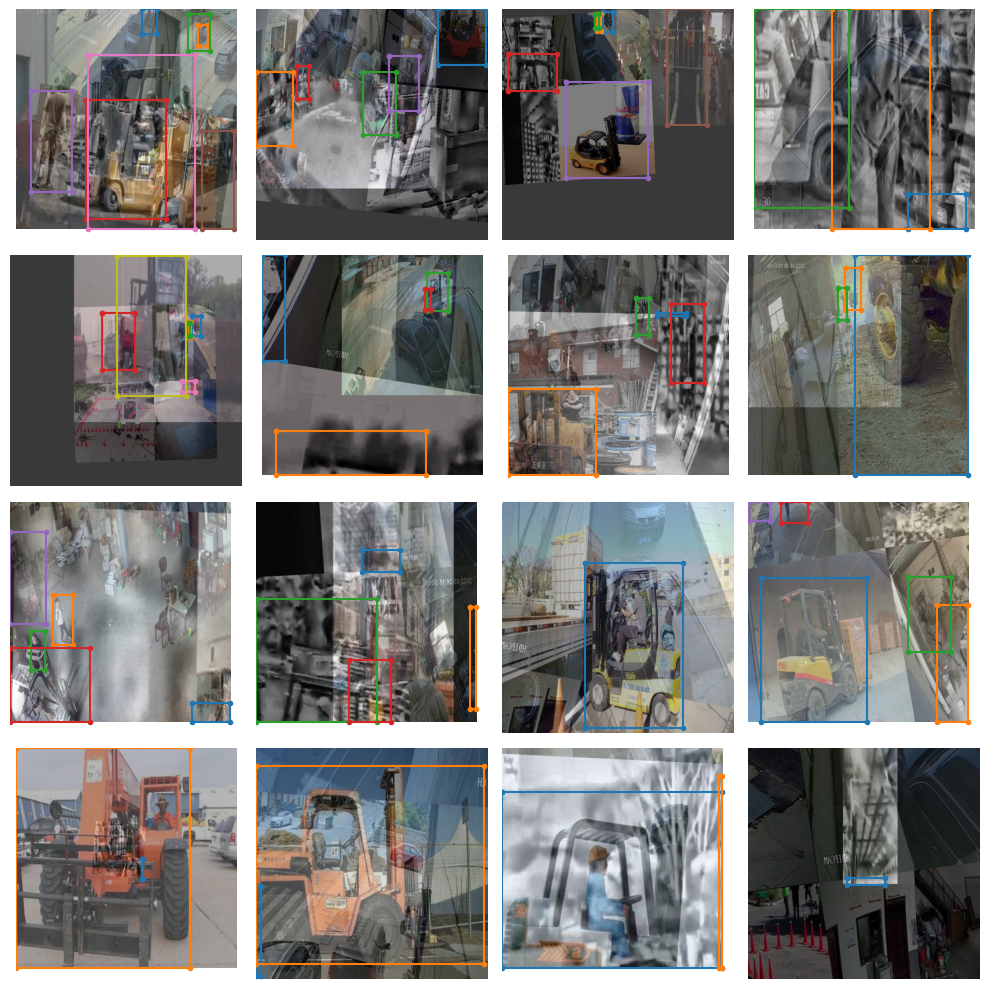

In [5]:
# Inspect Transformations Applied to Training Data
print("Transformations applied to training data:")
print(train_data.dataset.transforms)

# Visualize a Few Samples from Training Data
print("\nVisualizing samples from training data:")
train_data.dataset.plot()

# Train

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='forkligt_train', ckpt_root_dir=CHECKPOINT_DIR)

In [8]:
model = models.get('yolo_nas_s',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   ).to(device)

[2024-12-16 21:47:15] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-12-16 21:47:15] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s


In [9]:
train_params = {
    # ENABLING SILENT MODE
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 2,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}


In [10]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2024-12-16 21:47:21] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20241216_214721_132445`
[2024-12-16 21:47:21] INFO - sg_trainer.py - Checkpoints directory: checkpoints/forkligt_train/RUN_20241216_214721_132445
[2024-12-16 21:47:21] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


The console stream is now moved to checkpoints/forkligt_train/RUN_20241216_214721_132445/console_Dec16_21_47_21.txt


[2024-12-16 21:47:21] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            3284       (len(train_set))
    - Batch size per GPU:           8          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             8          (num_gpus * batch_size)
    - Effective Batch size:         8          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         410        (len(train_loader))
    - Gradient updates per epoch:   410        (len(train_loader) / batch_accumulate)
    - Model: YoloNAS_S  (19.02M parameters, 19.02M optimized)
    - Learning Rates and Weight Decays:
      - default: (19.02M parameters). LR: 0.0005 (19.02M parameters) WD: 0.0, (42.13K parameters), WD: 0.0001, (18.98M parameters)

[2024-12-16 21:47:21] INFO - sg_trainer.py - Started training for 2

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.7742
│   ├── Ppyoloeloss/loss_iou = 0.8619
│   ├── Ppyoloeloss/loss_dfl = 0.9096
│   └── Ppyoloeloss/loss = 3.5457
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.6792
    ├── Ppyoloeloss/loss_iou = 0.602
    ├── Ppyoloeloss/loss_dfl = 0.7457
    ├── Ppyoloeloss/loss = 3.0269
    ├── Precision@0.50 = 0.2321
    ├── Recall@0.50 = 0.1441
    ├── Map@0.50 = 0.0647
    └── F1@0.50 = 0.0964



Validating epoch 1: 100%|██████████| 125/125 [00:04<00:00, 29.95it/s]
[2024-12-16 21:48:50] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/forkligt_train/RUN_20241216_214721_132445/ckpt_best.pth
[2024-12-16 21:48:50] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.493988037109375


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.248
│   │   ├── Epoch N-1      = 1.7742 (↘ -0.5262)
│   │   └── Best until now = 1.7742 (↘ -0.5262)
│   ├── Ppyoloeloss/loss_iou = 0.6247
│   │   ├── Epoch N-1      = 0.8619 (↘ -0.2372)
│   │   └── Best until now = 0.8619 (↘ -0.2372)
│   ├── Ppyoloeloss/loss_dfl = 0.7404
│   │   ├── Epoch N-1      = 0.9096 (↘ -0.1693)
│   │   └── Best until now = 0.9096 (↘ -0.1693)
│   └── Ppyoloeloss/loss = 2.6131
│       ├── Epoch N-1      = 3.5457 (↘ -0.9327)
│       └── Best until now = 3.5457 (↘ -0.9327)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3574
    │   ├── Epoch N-1      = 1.6792 (↘ -0.3218)
    │   └── Best until now = 1.6792 (↘ -0.3218)
    ├── Ppyoloeloss/loss_iou = 0.4866
    │   ├── Epoch N-1      = 0.602  (↘ -0.1154)
    │   └── Best until now = 0.602  (↘ -0.1154)
    ├── Ppyoloeloss/loss_dfl = 0.6525
    │   ├── Epoch N-1      = 0.7457 (↘ -0.0932)
    │   └── Best until now = 0.7457 (↘ -0.0932)
    ├── Ppyoloeloss/los

[2024-12-16 21:48:55] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
Validating epoch 2: 100%|██████████| 125/125 [00:0

In [11]:
checkpoints_base_dir = "/home/LIBS/jozefov/projects/object_detection_avaltar/object_detection/src/final/checkpoints/forkligt_train"
checkpoint_dirs = [d for d in os.listdir(checkpoints_base_dir) if os.path.isdir(os.path.join(checkpoints_base_dir, d))]
checkpoint_dirs.sort()
latest_checkpoint_dir = checkpoint_dirs[-1]

latest_checkpoint_path = os.path.join(checkpoints_base_dir, latest_checkpoint_dir, 'ckpt_best.pth')

In [12]:
best_model = models.get('yolo_nas_s',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path=latest_checkpoint_path)

best_model.to(device)

[2024-12-16 21:49:02] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


YoloNAS_S(
  (backbone): NStageBackbone(
    (stem): YoloNASStem(
      (conv): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        )
        (branch_1x1): Conv2d(3, 48, kernel_size=(1, 1), stride=(2, 2))
        (post_bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (rbr_reparam): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
    )
    (stage1): YoloNASStage(
      (downsample): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=Tr

In [13]:

trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

[2024-12-16 21:49:04] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/LIBS/jozefov/projects/object_detection_avaltar/object_detection/src/final/checkpoints/forkligt_train/RUN_20241216_214721_132445/ckpt_best.pth EMA checkpoint.


Testing:  98%|█████████▊| 40/41 [00:01<00:00, 24.46it/s]

{'PPYoloELoss/loss_cls': 1.1943171,
 'PPYoloELoss/loss_iou': 0.47389483,
 'PPYoloELoss/loss_dfl': 0.6256081,
 'PPYoloELoss/loss': 2.2938194,
 'Precision@0.50': 0.01068627368658781,
 'Recall@0.50': 0.897607684135437,
 'mAP@0.50': 0.5496053695678711,
 'F1@0.50': 0.021121077239513397}

# EVAL with mAP

In [14]:
# Path to your COCO validation images
coco_val_directory = '/home/LIBS/jozefov/projects/object_detection_avaltar/object_detection/data/merged_forklift/test'

# List all jpg images in the validation directory
# Also important as on this will be based your sortings of prediction
image_paths = [os.path.join(coco_val_directory, img) for img in os.listdir(coco_val_directory) if img.endswith('.jpg')]

In [15]:
model_predictions = best_model.to(device).predict(image_paths, conf=0.20)

Testing: 100%|██████████| 41/41 [00:02<00:00, 20.48it/s]


It seems you are using predict() with batch input
Predicting Images:   0%|          | 0/326 [00:00<?, ?it/s]`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
[2024-12-16 21:49:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
Predicting Images:  89%|████████▊ | 289/326 [00:01<00:00, 202.39it/s]

In [44]:
# def generate_ground_truth(image_dir,label_dir, output_dir, class_mapping, model_predictions, input_format_truth='yolo', input_format_pred='voc'):
#     """
#     Converts YOLOv5 annotations and model predictions to the required format for mAP evaluation.

#     Args:
#         image_dir (str): Directory containing image files (e.g., JPG).
#         label_dir (str): Directory containing YOLOv5 TXT label files (class_id center_x center_y width height).
#                          The label files should have the same base name as the corresponding image
#                          files, with the extension .txt.
#         output_dir (str): Directory to save the ground-truth and detection-results files.
#                           The ground-truth files will be saved in `output_dir/ground-truth/` and
#                           the detection-results files will be saved in `output_dir/detection-results/`.
#         class_mapping (dict): A dictionary mapping class IDs (int) to class names (str).
#                               For example: {0: 'Dime', 1: 'Nickel', 2: 'Penny', 3: 'Quarter'}.
#         model_predictions (yolo-nas objects): model predictions                
#         input_format_truth (str, optional): The format of the input ground-truth bounding boxes.
#                                             Default is 'yolo', assuming YOLOv5 format.
#         input_format_pred (str, optional): The format of the input prediction bounding boxes.
#                                            Default is 'voc', assuming VOC format.

#     Returns:
#         None: The function writes the converted ground-truth and detection-results files to the specified
#               `output_dir` in a format compatible with the Cartucho/mAP evaluation tool.
#     """

#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)

#     gt_dir = os.path.join(output_dir, 'ground-truth')
#     dr_dir = os.path.join(output_dir, 'detection-results')
#     os.makedirs(gt_dir, exist_ok=True)
#     os.makedirs(dr_dir, exist_ok=True)


#     for image_name in os.listdir(image_dir):
#         if image_name.endswith('.jpg'):
#             # Extract the base name without extension to find the corresponding label file
#             base_name = os.path.splitext(image_name)[0]
#             label_file = os.path.join(label_dir, f"{base_name}.txt")

#             if not os.path.exists(label_file):
#                 print(f"Warning: Label file not found for image: {image_name}")
#                 continue

#             # Load the image to get its size
#             image_path = os.path.join(image_dir, image_name)
#             image = cv2.imread(image_path)
#             if image is None:
#                 print(f"Error: Could not load image: {image_name}")
#                 continue

#             image_height, image_width = image.shape[:2]
#             image_size = (image_width, image_height)

#             output_file = os.path.join(gt_dir, f"{base_name}.txt")

#             with open(label_file, 'r') as lf, open(output_file, 'w') as of:
#                 for line in lf:
#                     try:
#                         class_id, center_x, center_y, width, height = map(float, line.strip().split())
#                     except:
#                         continue

#                     bbox = [center_x, center_y, width, height]

#                     # Convert YOLO format (center_x, center_y, width, height) to (xmin, ymin, xmax, ymax)
#                     converted_bbox = pbx.convert_bbox(bbox, from_type=input_format_truth, to_type='coco', image_size=image_size)

#                     xmin, ymin, w, h = converted_bbox
#                     xmax = xmin + w
#                     ymax = ymin + h

#                     # Assuming class_id maps directly to category name
#                     class_name = class_mapping[int(class_id)]

#                     of.write(f"{class_name} {xmin} {ymin} {xmax} {ymax}\n")

#     # Process model predictions
#     for image_path, predictions in zip(image_paths, model_predictions):
#         image_file = os.path.basename(image_path)

#         if not os.path.exists(label_file):
#             print(f"Warning: Label file not found for image: {image_name}")
#             continue

#         image_path = os.path.join(image_dir, image_name)
#         image = cv2.imread(image_path)
#         if image is None:
#             print(f"Error: Could not load image: {image_name}")
#             continue

#         image_height, image_width = image.shape[:2]
#         image_size = (image_width, image_height)

#         output_file = os.path.join(dr_dir, image_file.replace('.jpg', '.txt'))

#         with open(output_file, 'w') as f:
#             for j, score in enumerate(predictions.prediction.confidence):
                
#                 category_name = predictions.class_names[int(predictions.prediction.labels[j])].replace(' ', '_')
#                 bbox = predictions.prediction.bboxes_xyxy[j]

#                 converted_back_bbox = pbx.convert_bbox(bbox, from_type=input_format_pred, to_type="coco", image_size=image_size)

#                 xmin, ymin, width, height = converted_back_bbox
#                 xmax = xmin + width
#                 ymax = ymin + height

#                 f.write(f"{category_name} {score} {xmin} {ymin} {xmax} {ymax}\n")


In [16]:
# clean folders
!rm -r /home/LIBS/jozefov/projects/object_detection_avaltar/libs/mAP/input/ground-truth/
!rm -r /home/LIBS/jozefov/projects/object_detection_avaltar/libs/mAP/input/detection-results/
!rm -r /home/LIBS/jozefov/projects/object_detection_avaltar/libs/mAP/input/images-optional

Predicting Images: 100%|██████████| 326/326 [00:01<00:00, 191.91it/s]


In [17]:
# Example usage:
image_dir = '/home/LIBS/jozefov/projects/object_detection_avaltar/object_detection/data/merged_forklift/test'
label_dir = '/home/LIBS/jozefov/projects/object_detection_avaltar/object_detection/data/merged_forklift/annotations/yolo_format_test'
output_dir = '/home/LIBS/jozefov/projects/object_detection_avaltar/libs/mAP/input'

class_mapping = {0: 'forklift', 1: 'person'}

generate_ground_truth(image_dir, label_dir, output_dir, class_mapping, model_predictions,  image_paths)

rm: cannot remove '/home/LIBS/jozefov/projects/object_detection_avaltar/libs/mAP/input/images-optional': No such file or directory


In [ ]:
!python /home/LIBS/jozefov/projects/object_detection_avaltar/libs/mAP/main.py -na

83.04% = forklift AP 
27.60% = person AP 
mAP = 55.32%


Figure(640x480)
